In [13]:
import pandas as pd

# Load IPUMS ACS microdata using chunked processing to handle large file
# Process in chunks to avoid memory issues
chunk_size = 500000  # Process 500k rows at a time
chunks = []

print("Loading IPUMS ACS microdata in chunks (this may take several minutes)...")

# Specify dtypes to reduce memory usage
dtypes = {
    'YEAR': 'int16',
    'STATEFIP': 'int8',
    'GQ': 'int8',
    'PERWT': 'float32',
    'INDNAICS': 'str',
    'MIGPLAC1': 'float32',
    'MIGRATE1': 'int8'
}

# Load only the columns we need
usecols = ['YEAR', 'STATEFIP', 'GQ', 'PERWT', 'INDNAICS', 'MIGPLAC1', 'MIGRATE1']

# Process file in chunks
for i, chunk in enumerate(pd.read_csv('../../Data Exploration/ipums_acs_extract.csv', 
                                    chunksize=chunk_size,
                                    dtype=dtypes, 
                                    usecols=usecols)):
    # Convert INDNAICS to string for consistent filtering
    chunk['INDNAICS'] = chunk['INDNAICS'].astype(str).str.strip()
    
    # Filter for film industry in each chunk (NAICS 512110 or codes starting with 5121)
    film_chunk = chunk[
        (chunk['INDNAICS'] == '512110') | 
        (chunk['INDNAICS'].str.startswith('5121'))
    ]
    
    # Basic cleaning
    film_chunk = film_chunk[
        (film_chunk['INDNAICS'] != '0') & 
        (film_chunk['INDNAICS'].notna()) & 
        (film_chunk['INDNAICS'] != '') &
        (film_chunk['PERWT'] != 0) & 
        (film_chunk['PERWT'].notna()) &
        (film_chunk['GQ'] == 1)
    ]
    
    if len(film_chunk) > 0:
        chunks.append(film_chunk)
    
    if (i + 1) % 10 == 0:  # Progress update every 10 chunks
        print(f"Processed {i+1} chunks...")

# Combine all chunks
if chunks:
    df = pd.concat(chunks, ignore_index=True)
    print(f"\nSuccessfully loaded {len(df)} film industry records")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024 / 1024:.1f} MB")
else:
    print("No film industry records found")
    df = pd.DataFrame()  # Empty dataframe as fallback

# Keep only relevant columns
cols_to_keep = ['YEAR', 'STATEFIP', 'MIGPLAC1', 'MIGRATE1', 'PERWT', 'INDNAICS']
if not df.empty:
    df = df[cols_to_keep]
    film_df = df.copy()  # This will be our working dataframe
    print(f"Final columns: {list(film_df.columns)}")
else:
    film_df = pd.DataFrame()  # Empty dataframe as fallback

Loading IPUMS ACS microdata in chunks (this may take several minutes)...
Processed 10 chunks...
Processed 20 chunks...
Processed 30 chunks...
Processed 40 chunks...
Processed 50 chunks...
Processed 60 chunks...
Processed 70 chunks...
Processed 80 chunks...
Processed 90 chunks...

Successfully loaded 78623 film industry records
Memory usage: 4.9 MB
Final columns: ['YEAR', 'STATEFIP', 'MIGPLAC1', 'MIGRATE1', 'PERWT', 'INDNAICS']


In [14]:
print(f"There are a total of {df.shape[0]} total entries")

There are a total of 78623 total entries


In [15]:
# Note: film_df was already created in Cell 0 with film industry filtering
# This cell is just for verification
print(f"Film industry workers: {film_df.shape[0]} records")
print(f"Years in data: {sorted(film_df['YEAR'].unique())}")

Film industry workers: 78623 records
Years in data: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [16]:
# Note: Data was already cleaned in Cell 0 (GQ filtering, INDNAICS validation, PERWT validation)
# This cell is just for verification
print(f"Current records: {film_df.shape[0]} records")
print(f"Columns: {list(film_df.columns)}")

Current records: 78623 records
Columns: ['YEAR', 'STATEFIP', 'MIGPLAC1', 'MIGRATE1', 'PERWT', 'INDNAICS']


In [17]:
# Columns are already filtered in Cell 0
# Just verify what we have
print(f"Columns: {list(film_df.columns)}")
print(f"Memory usage: {film_df.memory_usage(deep=True).sum() / 1024 / 1024:.1f} MB")

Columns: ['YEAR', 'STATEFIP', 'MIGPLAC1', 'MIGRATE1', 'PERWT', 'INDNAICS']
Memory usage: 4.9 MB


In [18]:
# Add is_interstate_mover column
# True if MIGPLAC1 is a valid state code and different from STATEFIP
# Valid state codes are 1-56 (excluding 3, 7, 14, 43, 52)
valid_states = set(range(1, 57)) - {3, 7, 14, 43, 52}

film_df['is_interstate_mover'] = (
    film_df['MIGPLAC1'].isin(valid_states) & 
    (film_df['MIGPLAC1'] != film_df['STATEFIP'])
)

In [19]:
# Display results
print("First 5 rows of film_df:")
display(film_df.head())

print(f"\nTotal weighted count: {film_df['PERWT'].sum():,.0f} people")
print(f"Unweighted count: {len(film_df):,} records")

First 5 rows of film_df:


,YEAR,STATEFIP,MIGPLAC1,MIGRATE1,PERWT,INDNAICS,is_interstate_mover
0,2009,1,0.0,1,28.0,5121,False
1,2009,1,0.0,1,110.0,5121,False
2,2009,1,0.0,1,85.0,5121,False
3,2009,1,0.0,1,116.0,5121,False
4,2009,1,0.0,1,73.0,5121,False



Total weighted count: 8,452,943 people
Unweighted count: 78,623 records


## Understanding Weighted Counts

The **weighted count** represents the estimated total number of people in the U.S. population that these survey responses represent. Each person in the survey has a weight (PERWT) that accounts for how many similar people they represent in the population. This corrects for sampling bias and ensures the data accurately reflects the true population size.

For example, if we have 72,232 survey responses representing 7.8 million film industry workers, this means these responses provide reliable estimates for approximately 7.8 million actual workers nationwide when properly weighted.

The **unweighted count** is simply the number of raw survey responses, which tells us about sample size but not population totals.

In [ ]:
# Analyze net inflow/outflow to California for all years
# California state code is 6
ca_fip = 6

print("Analyzing California film industry migration patterns...")

# Add is_interstate_mover column if it doesn't exist
# Valid state codes are 1-56 (excluding 3, 7, 14, 43, 52)
valid_states = set(range(1, 57)) - {3, 7, 14, 43, 52}
if 'is_interstate_mover' not in film_df.columns:
    film_df['is_interstate_mover'] = (
        film_df['MIGPLAC1'].isin(valid_states) & 
        (film_df['MIGPLAC1'] != film_df['STATEFIP'])
    )

# Get all available years
years = sorted(film_df['YEAR'].unique())
print(f"Analyzing data for years: {years}")

# Initialize results list
migration_results = []

print("\nProcessing migration analysis by year...")
for year in years:
    # Filter data for this year
    year_df = film_df[film_df['YEAR'] == year]
    
    # Calculate outflows FROM California (people who moved FROM CA to other states)
    # They lived in CA one year ago (MIGPLAC1 == 6) but now live elsewhere (STATEFIP != 6)
    outflows = year_df[
        (year_df['MIGPLAC1'] == ca_fip) & 
        (year_df['STATEFIP'] != ca_fip) &
        (year_df['is_interstate_mover'] == True)
    ]['PERWT'].sum()
    
    # Calculate inflows TO California (people who moved TO CA from other states)
    # They currently live in CA (STATEFIP == 6) but lived elsewhere one year ago (MIGPLAC1 != 6)
    inflows = year_df[
        (year_df['STATEFIP'] == ca_fip) & 
        (year_df['MIGPLAC1'] != ca_fip) &
        (year_df['is_interstate_mover'] == True)
    ]['PERWT'].sum()
    
    # Calculate net migration (positive = net inflow, negative = net outflow)
    net_migration = inflows - outflows
    
    # Total film workers in CA
    total_ca = year_df[year_df['STATEFIP'] == ca_fip]['PERWT'].sum()
    
    migration_results.append({
        'year': year,
        'inflows': inflows,
        'outflows': outflows,
        'net_migration': net_migration,
        'total_ca_film_workers': total_ca,
        'migration_rate': net_migration / total_ca if total_ca > 0 else 0
    })

# Create results DataFrame
results_df = pd.DataFrame(migration_results)

# Display results
print("\nCalifornia Film Industry Migration Analysis:")
print("=" * 70)
for _, row in results_df.iterrows():
    direction = "NET INFLOW" if row['net_migration'] > 0 else "NET OUTFLOW"
    print(f"{int(row['year'])}: {direction} of {abs(row['net_migration']):,.0f} workers")
    print(f"      Inflows: {row['inflows']:,.0f}, Outflows: {row['outflows']:,.0f}, Total CA workers: {row['total_ca_film_workers']:,.0f}")
    print(f"      Migration rate: {row['migration_rate']:.3%} of CA film workforce")
    print()

Analyzing California film industry migration patterns...
Analyzing data for years: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

Processing migration analysis by year...

California Film Industry Migration Analysis:
2009: NET INFLOW of 2,206 workers
      Inflows: 4,494, Outflows: 2,288, Total CA workers: 189,620
      Migration rate: 1.163% of CA film workforce

2010: NET INFLOW of 1,372 workers
      Inflows: 2,723, Outflows: 1,351, Total CA workers: 171,742
      Migration rate: 0.799% of CA film workforce

2011: NET INFLOW of 1,176 workers
      Inflows: 2,894, Outflows: 1,718, Total CA workers: 181,031
      Migration rate: 0.650% of CA film workforce

2012: NET INFLOW of 3,154 workers
      Inflows: 5,522, Outflows: 2,368, Total CA workers: 195,027
      Migration rate: 1.617% of CA film workforce

2013: NET INFLOW of 5,496 workers
      Inflows: 7,247, Outflows: 1,751, Total CA workers: 185,221
      Migration rate: 2.967% of CA film

Figure saved to: /Users/peterli/Documents/GitHub/as.180.369/contrib/peetyeety/Data Exploration/Migration/california_film_migration.png


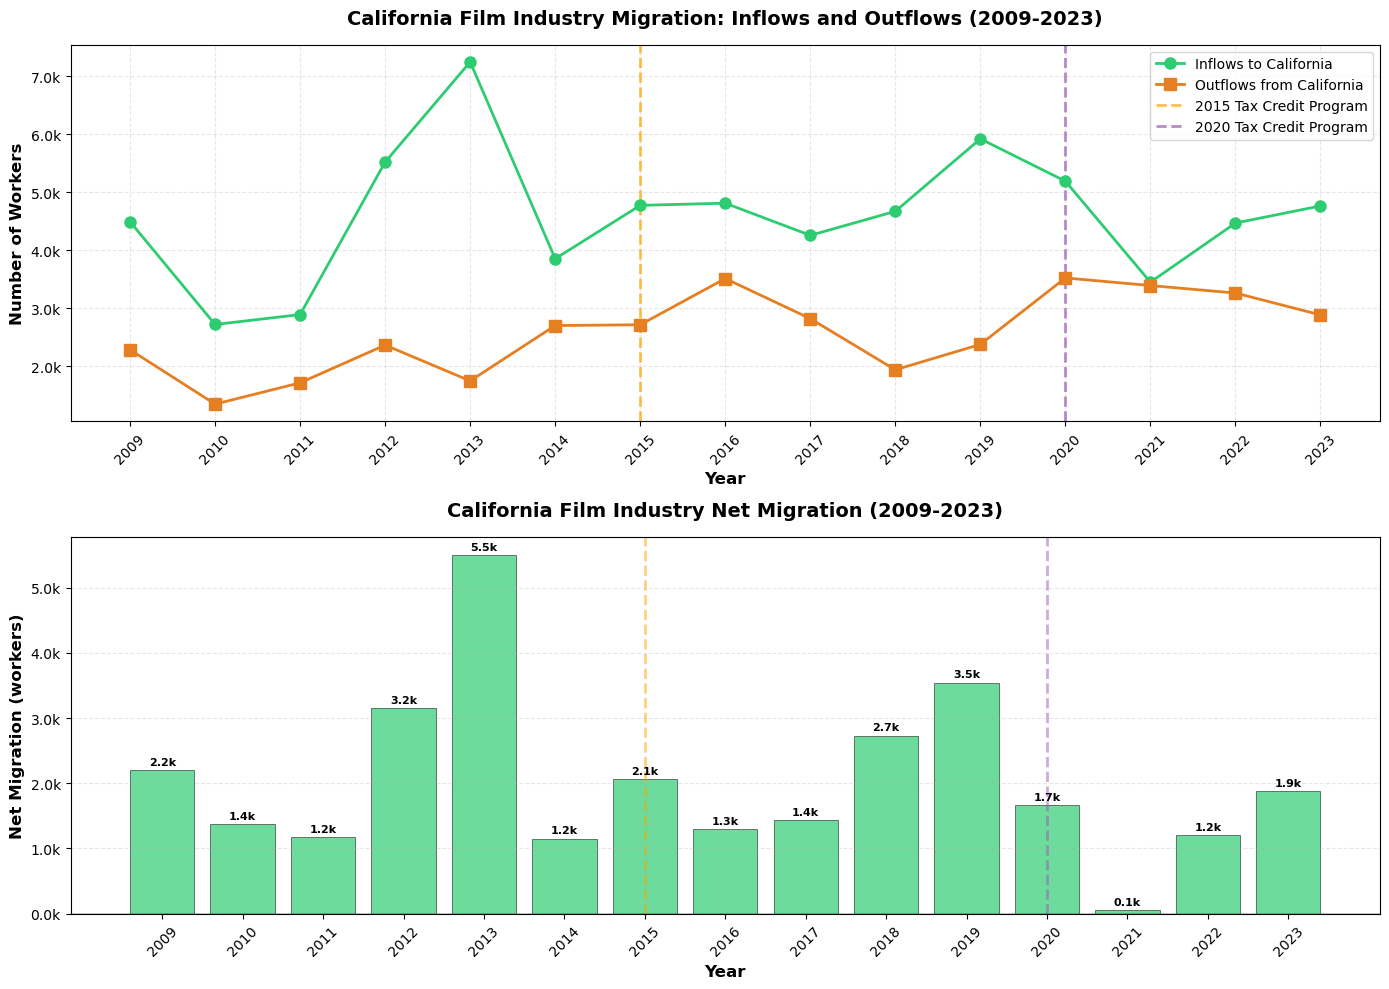

In [21]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# ===== SUBPLOT 1: Inflow and Outflow Over Time =====
ax1.plot(results_df['year'], results_df['inflows'], marker='o', linewidth=2, markersize=8, 
         color='#2ECC71', label='Inflows to California', zorder=3)  # Green
ax1.plot(results_df['year'], results_df['outflows'], marker='s', linewidth=2, markersize=8, 
         color='#E67E22', label='Outflows from California', zorder=3)  # Orange

# Add vertical lines for tax credit program years (2015 and 2020)
ax1.axvline(x=2015, color='#FFA500', linestyle='--', linewidth=2, alpha=0.7, 
            label='2015 Tax Credit Program', zorder=2)
ax1.axvline(x=2020, color='#9B59B6', linestyle='--', linewidth=2, alpha=0.7, 
            label='2020 Tax Credit Program', zorder=2)

ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Workers', fontsize=12, fontweight='bold')
ax1.set_title('California Film Industry Migration: Inflows and Outflows (2009-2023)', 
              fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, linestyle='--', zorder=1)
ax1.legend(loc='best', fontsize=10)
ax1.set_xticks(results_df['year'])
ax1.tick_params(axis='x', rotation=45)

# Format y-axis to show values in thousands
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.1f}k'))

# ===== SUBPLOT 2: Net Migration Bar Chart =====
# Color bars based on positive/negative values (green for positive, orange for negative)
colors = ['#E67E22' if x < 0 else '#2ECC71' for x in results_df['net_migration']]  # Orange for negative, Green for positive
bars = ax2.bar(results_df['year'], results_df['net_migration'], color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)

# Add horizontal line at zero
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)

# Add vertical lines for tax credit program years
ax2.axvline(x=2015, color='#FFA500', linestyle='--', linewidth=2, alpha=0.5, zorder=1)
ax2.axvline(x=2020, color='#9B59B6', linestyle='--', linewidth=2, alpha=0.5, zorder=1)

ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Net Migration (workers)', fontsize=12, fontweight='bold')
ax2.set_title('California Film Industry Net Migration (2009-2023)', 
              fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, linestyle='--', axis='y', zorder=1)
ax2.set_xticks(results_df['year'])
ax2.tick_params(axis='x', rotation=45)

# Format y-axis to show values in thousands
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.1f}k'))

# Add value labels on bars
for i, (year, net) in enumerate(zip(results_df['year'], results_df['net_migration'])):
    height = net
    ax2.text(year, height + (50 if height >= 0 else -200), f'{height/1000:.1f}k', 
             ha='center', va='bottom' if height >= 0 else 'top', fontsize=8, fontweight='bold')

plt.tight_layout()

# Get the current working directory (where the notebook is located)
notebook_dir = os.getcwd()
output_path = os.path.join(notebook_dir, 'california_film_migration.png')

# Save the figure
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {output_path}")

plt.show()


In [22]:
# Data Summary: Show unique values and counts for key variables
print("=" * 80)
print("DATA SUMMARY: Unique Values and Counts")
print("=" * 80)

print("\n1. YEARS in dataset:")
print("-" * 40)
if not film_df.empty:
    year_counts = film_df['YEAR'].value_counts().sort_index()
    print(f"Total unique years: {film_df['YEAR'].nunique()}")
    print(f"Years present: {sorted(film_df['YEAR'].unique())}")
    print("\nYear counts (unweighted):")
    for year, count in year_counts.items():
        weighted_total = film_df[film_df['YEAR'] == year]['PERWT'].sum()
        print(f"  {int(year)}: {count:,} records (weighted: {weighted_total:,.0f} people)")
else:
    print("No data available")

print("\n2. STATE FIPS codes in dataset:")
print("-" * 40)
if not film_df.empty:
    state_counts = film_df['STATEFIP'].value_counts().sort_index()
    print(f"Total unique states: {film_df['STATEFIP'].nunique()}")
    print(f"State FIPS codes present: {sorted(film_df['STATEFIP'].unique())}")
    print("\nTop 10 states by record count:")
    for state, count in state_counts.head(10).items():
        weighted_total = film_df[film_df['STATEFIP'] == state]['PERWT'].sum()
        print(f"  State {int(state)}: {count:,} records (weighted: {weighted_total:,.0f} people)")
else:
    print("No data available")

print("\n3. MIGPLAC1 (State of residence one year prior) values:")
print("-" * 40)
if not film_df.empty:
    migplac_counts = film_df['MIGPLAC1'].value_counts().sort_index()
    print(f"Total unique MIGPLAC1 values: {film_df['MIGPLAC1'].nunique()}")
    print(f"Unique MIGPLAC1 values: {sorted([x for x in film_df['MIGPLAC1'].unique() if pd.notna(x)])}")
    print("\nMIGPLAC1 value counts (top 15):")
    for migplac, count in migplac_counts.head(15).items():
        if pd.notna(migplac):
            weighted_total = film_df[film_df['MIGPLAC1'] == migplac]['PERWT'].sum()
            print(f"  {int(migplac)}: {count:,} records (weighted: {weighted_total:,.0f} people)")
    # Count missing/zero values
    missing_count = film_df['MIGPLAC1'].isna().sum() + (film_df['MIGPLAC1'] == 0).sum()
    if missing_count > 0:
        print(f"  Missing/0: {missing_count:,} records (non-movers or missing data)")
else:
    print("No data available")

print("\n4. MIGRATE1 (Migration status) values:")
print("-" * 40)
if not film_df.empty:
    migrate_counts = film_df['MIGRATE1'].value_counts().sort_index()
    print(f"Total unique MIGRATE1 values: {film_df['MIGRATE1'].nunique()}")
    print(f"MIGRATE1 values present: {sorted(film_df['MIGRATE1'].unique())}")
    print("\nMIGRATE1 value counts:")
    for migrate, count in migrate_counts.items():
        weighted_total = film_df[film_df['MIGRATE1'] == migrate]['PERWT'].sum()
        migrate_label = {
            1: "Same house",
            2: "Same county, different house",
            3: "Different county, same state",
            4: "Different state",
            5: "Abroad"
        }.get(int(migrate), "Unknown")
        print(f"  {int(migrate)} ({migrate_label}): {count:,} records (weighted: {weighted_total:,.0f} people)")
else:
    print("No data available")

print("\n5. California-specific summary:")
print("-" * 40)
if not film_df.empty:
    ca_fip = 6
    ca_data = film_df[film_df['STATEFIP'] == ca_fip]
    print(f"Total CA records: {len(ca_data):,}")
    print(f"Total CA weighted count: {ca_data['PERWT'].sum():,.0f} people")
    print(f"Years with CA data: {sorted(ca_data['YEAR'].unique())}")
    print(f"\nCA records by year:")
    for year in sorted(ca_data['YEAR'].unique()):
        year_data = ca_data[ca_data['YEAR'] == year]
        print(f"  {int(year)}: {len(year_data):,} records (weighted: {year_data['PERWT'].sum():,.0f} people)")
else:
    print("No data available")

print("\n" + "=" * 80)


DATA SUMMARY: Unique Values and Counts

1. YEARS in dataset:
----------------------------------------
Total unique years: 15
Years present: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

Year counts (unweighted):
  2009: 4,758 records (weighted: 506,303 people)
  2010: 4,682 records (weighted: 488,591 people)
  2011: 4,460 records (weighted: 491,213 people)
  2012: 4,722 records (weighted: 522,741 people)
  2013: 4,825 records (weighted: 514,555 people)
  2014: 4,912 records (weighted: 520,216 people)
  2015: 5,040 records (weighted: 542,166 people)
  2016: 5,261 records (weighted: 555,655 people)
  2017: 5,769 records (weighted: 598,965 people)
  2018: 5,441 records (weighted: 565,837 people)
  2019: 5,868 records (weighted: 595,817 people)
  2020: 4,723 records (weighted: 654,590 people)
  2021: 5,622 records (weighted: 586,048 people)
  2022: 6,149 records (weighted: 642,021 people)
  2023: 6,391 records (weighted: 668,225 people)

2. STA

## Methodology: Classifying Inflows and Outflows

### Overview

This analysis uses IPUMS ACS microdata to measure interstate migration of film industry workers to and from California. The ACS provides two key variables for identifying migration:

- **`STATEFIP`**: Current state of residence (at time of survey)
- **`MIGPLAC1`**: State of residence one year prior to the survey

### Data Filters

**Industry Classification (NAICS):**
- Included: NAICS code `512110` (Motion Picture and Video Production) and all codes starting with `5121`
- Excluded: Missing, zero, or empty industry codes

**Population Scope:**
- Included: Household population only (`GQ == 1`)
- Excluded: Institutional and group quarters populations
- Included: Records with valid, non-zero person weights (`PERWT`)

**Geographic Scope:**
- Valid state codes: 1-56, excluding codes 3, 7, 14, 43, 52 (Alaska, Delaware, Hawaii, Montana, Wyoming)
- California FIPS code: 6

### Identifying Interstate Movers

An **interstate mover** is defined as a person who:
1. Has a valid state code in `MIGPLAC1` (not missing, not zero)
2. Has `MIGPLAC1 != STATEFIP` (lived in a different state one year ago)

This classification excludes:
- Non-movers (same state one year ago and currently)
- Intrastate movers (moved within the same state)
- Missing migration data

### Classifying Outflows from California

**Outflow** = Weighted count of workers who:
- Currently reside in California (`STATEFIP == 6`)
- Are interstate movers (`MIGPLAC1 != STATEFIP` and `MIGPLAC1` is valid)

**Interpretation:** These are workers who moved *from* California to another state between year t-1 and year t. They represent a loss of film industry workers from California's workforce.

**Formula:**
```
Outflows_t = Σ PERWT_i for all i where:
  STATEFIP_i = 6 (California)
  AND MIGPLAC1_i is a valid state code
  AND MIGPLAC1_i ≠ STATEFIP_i (interstate mover)
```

### Classifying Inflows to California

**Inflow** = Weighted count of workers who:
- Currently reside in California (`STATEFIP == 6`)
- Lived in a different state one year ago (`MIGPLAC1 != 6` and `MIGPLAC1` is valid)
- Are interstate movers (`MIGPLAC1 != STATEFIP`)

**Interpretation:** These are workers who moved *to* California from another state between year t-1 and year t. They represent a gain of film industry workers to California's workforce.

**Formula:**
```
Inflows_t = Σ PERWT_i for all i where:
  STATEFIP_i = 6 (California)
  AND MIGPLAC1_i is a valid state code
  AND MIGPLAC1_i ≠ STATEFIP_i (interstate mover)
  AND MIGPLAC1_i ≠ 6 (moved from outside California)
```

### Net Migration Calculation

**Net Migration** = Inflows - Outflows

- **Positive values** indicate net inflow (more workers moving to California than leaving)
- **Negative values** indicate net outflow (more workers leaving California than arriving)

**Migration Rate** = (Net Migration / Total CA Film Workers) × 100%

This rate expresses net migration as a percentage of California's total film industry workforce, providing a standardized measure of migration intensity relative to workforce size.

### Important Considerations

1. **Temporal Reference:** ACS migration questions ask about residence "one year ago," so 2015 survey responses capture moves between 2014 and 2015.

2. **Permanent vs. Temporary Migration:** ACS captures permanent state-to-state moves. Temporary relocations for specific productions are not captured, which may explain discrepancies between employment gains (from QCEW) and migration patterns (from ACS).

3. **Weighting:** All counts use person weights (`PERWT`) to represent population totals, accounting for ACS sampling design and ensuring estimates reflect the true population of film industry workers.

4. **Limitations:** This analysis excludes international migration (moves from abroad) and focuses solely on interstate migration within the United States.
